In [1]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.2 MB/s eta 0:00:00


In [2]:
# main.py
# Implementation of Neural Machine Translation in pytorch.
# Dataset: https://huggingface.co/datasets/ted_hrlr
# (https://huggingface.co/datasets/ted_hrlr/viewer/pt_to_en)


from __future__ import unicode_literals, print_function, division
from io import open
import json
import logging
import math
import random
import re
import time
import unicodedata

from datasets import load_dataset
import transformers
from transformers import AutoTokenizer

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from torch.utils.data import Dataset, dataloader

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Set device.
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
if torch.backends.mps.is_available():
    device = "mps"
print(f"Compute Device chosen: {device}")

Compute Device chosen: cuda


In [5]:
# Load the data.
data = load_dataset("ted_hrlr", "pt_to_en")
train_examples, val_examples = data["train"], data["validation"]
# print(train_examples)
# print(train_examples["translation"])
print("Translations:")
print(json.dumps(train_examples["translation"][:3], indent=4))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/51786 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1194 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1804 [00:00<?, ? examples/s]

Translations:
[
    {
        "en": "amongst all the troubling deficits we struggle with today \u2014 we think of financial and economic primarily \u2014 the ones that concern me most is the deficit of political dialogue \u2014 our ability to address modern conflicts as they are , to go to the source of what they 're all about and to understand the key players and to deal with them .",
        "pt": "entre todas as grandes priva\u00e7\u00f5es com que nos debatemos hoje \u2014 pensamos em financeiras e econ\u00f3micas primeiro \u2014 aquela que mais me preocupa \u00e9 a falta de di\u00e1logo pol\u00edtico \u2014 a nossa capacidade de abordar conflitos modernos como eles s\u00e3o , de ir \u00e0 raiz do que eles s\u00e3o e perceber os agentes-chave e lidar com eles ."
    },
    {
        "en": "we who are diplomats , we are trained to deal with conflicts between states and issues between states .",
        "pt": "n\u00f3s que somos diplomatas , somos treinados para lidar com conflitos en

In [6]:
# Original example used a pretrained tensorflow subword tokenizer. It
# is not possible to convert this tokenizer to pytorch quickly. I was
# going to use the tokenizer devised in this pytorch example/tutorial:
# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
# however, this was primarily for the english to french translation
# dataset (provided in that pytorch example) and didnt have the
# necessary data for english to portuguese translation done in the
# tensorflow example. I decided to use this multilingual tokenizer for
# BERT multilingual base cased (thank you Google):
# https://huggingface.co/google-bert/bert-base-multilingual-cased
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [7]:
# Test tokenizer.
samples = train_examples["translation"][:3]
en_pt = [(sample["en"], sample["pt"]) for sample in samples]
en = [sample[0] for sample in en_pt]
pt = [sample[1] for sample in en_pt]
print("> English:")
print(f"{en[0]}")
print("> English tokenized:")
print(tokenizer.encode(en[0]))
print("> Portuguese:")
print(f"{pt[0]}")
print("> Portuguese tokenized:")
print(tokenizer.encode(pt[0]))

> English:
amongst all the troubling deficits we struggle with today — we think of financial and economic primarily — the ones that concern me most is the deficit of political dialogue — our ability to address modern conflicts as they are , to go to the source of what they 're all about and to understand the key players and to deal with them .
> English tokenized:
[101, 48593, 10435, 10105, 42169, 20664, 11945, 107383, 10107, 11951, 48919, 10169, 18745, 100, 11951, 27874, 10108, 20570, 10111, 13925, 22426, 100, 10105, 35688, 10189, 43607, 10911, 10992, 10124, 10105, 107383, 10108, 13736, 51077, 100, 17446, 23599, 10114, 32198, 13456, 83594, 10146, 10689, 10301, 117, 10114, 11783, 10114, 10105, 15247, 10108, 12976, 10689, 112, 11639, 10435, 10978, 10111, 10114, 49151, 10105, 18444, 16021, 10111, 10114, 19918, 10169, 11345, 119, 102]
> Portuguese:
entre todas as grandes privações com que nos debatemos hoje — pensamos em financeiras e económicas primeiro — aquela que mais me preocupa é a 

In [8]:
# Use pytorch dataset to do the translation.
class TranslationDataset(Dataset):
    def __init__(self, hf_dataset, tokenizer, max_tokens):
        super().__init__()
        self.dataset = hf_dataset["translation"]
        self.tokenizer = tokenizer
        self.max_tokens = max_tokens


    def __len__(self):
        return len(self.dataset)


    def __getitem__(self, idx):
        sample = self.dataset[idx]

        # Tokenize the texts. Dont forget to pad and truncate to
        # MAX_TOKENS. Reference guide here:
        # https://huggingface.co/docs/transformers/en/pad_truncation
        en_tokens = tokenizer.encode(
            sample["en"],
            truncation=True,
            max_length=self.max_tokens,
            padding="max_length",
            return_tensors="pt"
        )
        pt_tokens = tokenizer.encode(
            sample["pt"],
            truncation=True,
            max_length=self.max_tokens,
            padding="max_length",
            return_tensors="pt"
        )

        return {
            "en_inputs": en_tokens[:, :-1],
            "en_labels": en_tokens[:, 1:],
            "pt": pt_tokens
        }


In [9]:
# Use pytorch dataset to do the translation.
class TranslationDataset(Dataset):
    def __init__(self, hf_dataset, tokenizer, max_tokens):
        super().__init__()
        self.dataset = hf_dataset["translation"]
        self.tokenizer = tokenizer
        self.max_tokens = max_tokens


    def __len__(self):
        return len(self.dataset)


    def __getitem__(self, idx):
        sample = self.dataset[idx]

        # Tokenize the texts. Dont forget to pad and truncate to
        # MAX_TOKENS. Reference guide here:
        # https://huggingface.co/docs/transformers/en/pad_truncation
        en_tokens = tokenizer.encode(
            sample["en"],
            truncation=True,
            max_length=self.max_tokens,
            padding="max_length",
            return_tensors="pt"
        )
        pt_tokens = tokenizer.encode(
            sample["pt"],
            truncation=True,
            max_length=self.max_tokens,
            padding="max_length",
            return_tensors="pt"
        )

        return {
            "en_inputs": en_tokens[:, :-1],
            "en_labels": en_tokens[:, 1:],
            "en": en_tokens,
            "pt": pt_tokens
        }

In [10]:
# Pass the huggingface dataset through the custom dataset subclass for
# each split.
MAX_TOKENS = 128
train_set = TranslationDataset(train_examples, tokenizer, MAX_TOKENS)
valid_set = TranslationDataset(val_examples, tokenizer, MAX_TOKENS)


In [11]:
# Batch the dataset with a dataloader.
BATCH_SIZE = 8#64
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True
)
valid_loader = DataLoader(
    valid_set,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [12]:
# Test dataset.
train_features = next(iter(train_loader))
print(f"> inputs")
print(train_features["en_inputs"])
print(train_features["pt"])
print(f"> outputs")
print(train_features["en_labels"])

> inputs
tensor([[[  101, 11426, 10301,  ...,     0,     0,     0]],

        [[  101, 10105,   109,  ...,     0,     0,     0]],

        [[  101, 10689,   117,  ...,     0,     0,     0]],

        ...,

        [[  101, 12132, 10440,  ...,     0,     0,     0]],

        [[  101, 10944, 51747,  ...,     0,     0,     0]],

        [[  101, 19457, 22623,  ...,     0,     0,     0]]])
tensor([[[  101, 10146, 21000,  ...,     0,     0,     0]],

        [[  101,   169, 93070,  ...,     0,     0,     0]],

        [[  101, 46853, 10104,  ...,     0,     0,     0]],

        ...,

        [[  101, 12078, 11039,  ...,     0,     0,     0]],

        [[  101, 10164, 46985,  ...,     0,     0,     0]],

        [[  101, 10176, 68204,  ...,     0,     0,     0]]])
> outputs
tensor([[[11426, 10301, 69463,  ...,     0,     0,     0]],

        [[10105,   109, 10407,  ...,     0,     0,     0]],

        [[10689,   117, 16038,  ...,     0,     0,     0]],

        ...,

        [[12132, 10440, 

In [13]:
pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 444.8 kB/s eta 0:00:00


In [14]:
import sys

# Add the directory containing scans.py to the Python path
sys.path.append("/content/drive/MyDrive/Colab Notebooks/")



In [15]:
import torch
from torch.nn import functional as F


def complex_log(input, eps=1e-12):
    eps = input.new_tensor(eps)
    real = input.abs().maximum(eps).log()
    imag = (input < 0).to(input.dtype) * torch.pi
    return torch.complex(real, imag)


def selective_scan(u, dt, A, B, C, D, mode='cumsum'):
    dA = torch.einsum('bld,dn->bldn', dt, A)
    dB_u = torch.einsum('bld,bld,bln->bldn', dt, u, B)

    match mode:
        case 'cumsum':
            dA_cumsum = F.pad(dA[:, 1:], (0, 0, 0, 0, 0, 1)).flip(1).cumsum(1).exp().flip(1)
            x = dB_u * dA_cumsum
            x = x.cumsum(1) / (dA_cumsum + 1e-12)
            y = torch.einsum('bldn,bln->bld', x, C)

            return y + u * D

        case 'logcumsumexp':
            dB_u_log = complex_log(dB_u)

            dA_star = F.pad(dA[:, 1:].cumsum(1), (0, 0, 0, 0, 1, 0))
            x_log = torch.logcumsumexp(dB_u_log - dA_star, 1) + dA_star

            y = torch.einsum('bldn,bln->bld', x_log.real.exp() * torch.cos(x_log.imag), C)
            return y + u * D

In [16]:
"""Simple, minimal implementation of Mamba in one file of PyTorch.

Suggest reading the following before/while reading the code:
    [1] Mamba: Linear-Time Sequence Modeling with Selective State Spaces (Albert Gu and Tri Dao)
        https://arxiv.org/abs/2312.00752
    [2] The Annotated S4 (Sasha Rush and Sidd Karamcheti)
        https://srush.github.io/annotated-s4

Glossary:
    b: batch size                       (`B` in Mamba paper [1] Algorithm 2)
    l: sequence length                  (`L` in [1] Algorithm 2)
    d or d_model: hidden dim
    n or d_state: latent state dim      (`N` in [1] Algorithm 2)
    expand: expansion factor            (`E` in [1] Section 3.4)
    d_in or d_inner: d * expand         (`D` in [1] Algorithm 2)
    A, B, C, D: state space parameters  (See any state space representation formula)
                                        (B, C are input-dependent (aka selective, a key innovation in Mamba); A, D are not)
    Δ or delta: input-dependent step size
    dt_rank: rank of Δ                  (See [1] Section 3.6 "Parameterization of ∆")

"""
from __future__ import annotations

import json
import math
from dataclasses import dataclass
from typing import Union

import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, repeat


@dataclass
class ModelArgs:
    d_model: int
    n_layer: int
    vocab_size: int
    d_state: int = 16
    expand: int = 2
    dt_rank: Union[int, str] = 'auto'
    d_conv: int = 4
    pad_vocab_size_multiple: int = 8
    conv_bias: bool = True
    bias: bool = False
    scan_mode: str = 'cumsum'

    def __post_init__(self):
        self.d_inner = int(self.expand * self.d_model)

        if self.dt_rank == 'auto':
            self.dt_rank = math.ceil(self.d_model / 16)

        if self.vocab_size % self.pad_vocab_size_multiple != 0:
            self.vocab_size += (self.pad_vocab_size_multiple
                                - self.vocab_size % self.pad_vocab_size_multiple)


class Mamba(nn.Module):
    def __init__(self, args: ModelArgs):
        """Full Mamba model."""
        super().__init__()
        self.args = args

        self.embedding = nn.Embedding(args.vocab_size, args.d_model)
        self.layers = nn.ModuleList([ResidualBlock(args) for _ in range(args.n_layer)])
        self.norm_f = RMSNorm(args.d_model)

        self.lm_head = nn.Linear(args.d_model, args.vocab_size, bias=False)
        self.lm_head.weight = self.embedding.weight  # Tie output projection to embedding weights.
                                                     # See "Weight Tying" paper

    def forward(self, input_ids):
        """
        Args:
            input_ids (long tensor): shape (b, l)    (See Glossary at top for definitions of b, l, d_in, n...)

        Returns:
            logits: shape (b, l, vocab_size)

        Official Implementation:
            class MambaLMHeadModel, https://github.com/state-spaces/mamba/blob/main/mamba_ssm/models/mixer_seq_simple.py#L173

        """
        x = self.embedding(input_ids)

        for layer in self.layers:
            x = layer(x)

        x = self.norm_f(x)
        return self.lm_head(x)

    @staticmethod
    def from_pretrained(pretrained_model_name: str, model=None):
        """Load pretrained weights from HuggingFace into model.

        Args:
            pretrained_model_name: One of
                * 'state-spaces/mamba-2.8b-slimpj'
                * 'state-spaces/mamba-2.8b'
                * 'state-spaces/mamba-1.4b'
                * 'state-spaces/mamba-790m'
                * 'state-spaces/mamba-370m'
                * 'state-spaces/mamba-130m'

        Returns:
            model: Mamba model with weights loaded

        """
        from transformers.utils import CONFIG_NAME, WEIGHTS_NAME
        from transformers.utils.hub import cached_file

        def load_config_hf(model_name):
            resolved_archive_file = cached_file(model_name, CONFIG_NAME,
                                                _raise_exceptions_for_missing_entries=False)
            return json.load(open(resolved_archive_file))


        def load_state_dict_hf(model_name, device=None, dtype=None):
            resolved_archive_file = cached_file(model_name, WEIGHTS_NAME,
                                                _raise_exceptions_for_missing_entries=False)
            return torch.load(resolved_archive_file, weights_only=True, map_location='cpu', mmap=True)

        if model is None:
            config_data = load_config_hf(pretrained_model_name)
            model = Mamba(ModelArgs(
                d_model=config_data['d_model'],
                n_layer=config_data['n_layer'],
                vocab_size=config_data['vocab_size'],
            ))

        pretrained_dict = load_state_dict_hf(pretrained_model_name)
        model_dict = model.state_dict()

        for k, v in pretrained_dict.items():
            k_new = k.replace('backbone.', '')
            if k_new in model_dict and v.size() == model_dict[k_new].size():
                model_dict[k_new] = pretrained_dict[k]

        model.load_state_dict(model_dict)
        return model


class ResidualBlock(nn.Module):
    def __init__(self, args: ModelArgs):
        """Simple block wrapping Mamba block with normalization and residual connection."""
        super().__init__()
        self.args = args
        self.mixer = MambaBlock(args)
        self.norm = RMSNorm(args.d_model)

    def forward(self, x):
        """
        Args:
            x: shape (b, l, d)    (See Glossary at top for definitions of b, l, d_in, n...)

        Returns:
            output: shape (b, l, d)

        Official Implementation:
            Block.forward(), https://github.com/state-spaces/mamba/blob/main/mamba_ssm/modules/mamba_simple.py#L297

            Note: the official repo chains residual blocks that look like
                [Add -> Norm -> Mamba] -> [Add -> Norm -> Mamba] -> [Add -> Norm -> Mamba] -> ...
            where the first Add is a no-op. This is purely for performance reasons as this
            allows them to fuse the Add->Norm.

            We instead implement our blocks as the more familiar, simpler, and numerically equivalent
                [Norm -> Mamba -> Add] -> [Norm -> Mamba -> Add] -> [Norm -> Mamba -> Add] -> ....

        """
        return self.mixer(self.norm(x)) + x


class MambaBlock(nn.Module):
    def __init__(self, args: ModelArgs):
        """A single Mamba block, as described in Figure 3 in Section 3.4 in the Mamba paper [1]."""
        super().__init__()
        self.args = args

        self.in_proj = nn.Linear(args.d_model, args.d_inner * 2, bias=args.bias)

        self.conv1d = nn.Conv1d(
            in_channels=args.d_inner,
            out_channels=args.d_inner,
            bias=args.conv_bias,
            kernel_size=args.d_conv,
            groups=args.d_inner,
            padding=args.d_conv - 1,
        )

        # x_proj takes in `x` and outputs the input-specific Δ, B, C
        self.x_proj = nn.Linear(args.d_inner, args.dt_rank + args.d_state * 2, bias=False)

        # dt_proj projects Δ from dt_rank to d_in
        self.dt_proj = nn.Linear(args.dt_rank, args.d_inner, bias=True)

        A = repeat(torch.arange(1, args.d_state + 1), 'n -> d n', d=args.d_inner)
        self.A_log = nn.Parameter(torch.log(A))
        self.D = nn.Parameter(torch.ones(args.d_inner))
        self.out_proj = nn.Linear(args.d_inner, args.d_model, bias=args.bias)

    def forward(self, x):
        """Mamba block forward. This looks the same as Figure 3 in Section 3.4 in the Mamba paper [1].

        Args:
            x: shape (b, l, d)    (See Glossary at top for definitions of b, l, d_in, n...)

        Returns:
            output: shape (b, l, d)

        Official Implementation:
            class Mamba, https://github.com/state-spaces/mamba/blob/main/mamba_ssm/modules/mamba_simple.py#L119
            mamba_inner_ref(), https://github.com/state-spaces/mamba/blob/main/mamba_ssm/ops/selective_scan_interface.py#L311

        """
        (b, l, d) = x.shape

        x_and_res = self.in_proj(x)  # shape (b, l, 2 * d_in)
        (x, res) = x_and_res.split(split_size=[self.args.d_inner, self.args.d_inner], dim=-1)

        x = rearrange(x, 'b l d_in -> b d_in l')
        x = self.conv1d(x)[:, :, :l]
        x = rearrange(x, 'b d_in l -> b l d_in')

        x = F.silu(x)

        y = self.ssm(x)

        y = y * F.silu(res)

        return self.out_proj(y)

    def ssm(self, x):
        """Runs the SSM. See:
            - Algorithm 2 in Section 3.2 in the Mamba paper [1]
            - run_SSM(A, B, C, u) in The Annotated S4 [2]

        Args:
            x: shape (b, l, d_in)    (See Glossary at top for definitions of b, l, d_in, n...)

        Returns:
            output: shape (b, l, d_in)

        Official Implementation:
            mamba_inner_ref(), https://github.com/state-spaces/mamba/blob/main/mamba_ssm/ops/selective_scan_interface.py#L311

        """
        (d_in, n) = self.A_log.shape

        # Compute ∆ A B C D, the state space parameters.
        #     A, D are input independent (see Mamba paper [1] Section 3.5.2 "Interpretation of A" for why A isn't selective)
        #     ∆, B, C are input-dependent (this is a key difference between Mamba and the linear time invariant S4,
        #                                  and is why Mamba is called **selective** state spaces)

        A = -torch.exp(self.A_log.float())  # shape (d_in, n)
        D = self.D.float()

        x_dbl = self.x_proj(x)  # (b, l, dt_rank + 2*n)

        (delta, B, C) = x_dbl.split(split_size=[self.args.dt_rank, n, n], dim=-1)  # delta: (b, l, dt_rank). B, C: (b, l, n)
        delta = F.softplus(self.dt_proj(delta))  # (b, l, d_in)

        return selective_scan(x, delta, A, B, C, D, mode=self.args.scan_mode)  # This is similar to run_SSM(A, B, C, u) in The Annotated S4 [2]


class RMSNorm(nn.Module):
    def __init__(self,
                 d_model: int,
                 eps: float = 1e-5):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(d_model))

    def forward(self, x):
        output = x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps) * self.weight

        return output

In [17]:
# Hyperparameters.
src_vocab_size = tokenizer.vocab_size
tgt_vocab_size = tokenizer.vocab_size
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
# max_seq_length = 100
max_seq_length = MAX_TOKENS
dropout = 0.1

In [18]:
# Create an instance of the Mamba model
model_args = ModelArgs(
    d_model=d_model,                  # Hidden dimension
    n_layer=num_layers,               # Number of layers
    vocab_size=tokenizer.vocab_size,  # Vocabulary size
    d_state=16,                       # Latent state dimension
    expand=2,                         # Expansion factor
    dt_rank='auto',                   # Rank of Δ
    d_conv=4,                         # Convolutional dimension
    pad_vocab_size_multiple=8,        # Multiple of vocabulary size for padding
    conv_bias=True,                   # Whether to include bias in convolution
    bias=False,                       # Whether to include bias in linear layers
    scan_mode='cumsum'                # Scan mode
)
mamba_model = Mamba(model_args)
mamba_model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(mamba_model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [19]:
import os
import torch

checkpoint_dir = "/content/checkpoints/"
if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_files = [file for file in os.listdir(checkpoint_dir) if file.endswith('.pt')]

if checkpoint_files:
    latest_checkpoint = max(checkpoint_files)

    latest_checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)

    checkpoint = torch.load(latest_checkpoint_path)

    start_epoch = checkpoint['epoch'] + 1
    mamba.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']

    print(f"Loading latest checkpoint: {latest_checkpoint_path}")
    print(f"Starting training from epoch {start_epoch}, Loss: {loss}")
else:
    print("No checkpoint files found in the directory.")
    start_epoch = 0  # start_epoch when no checkpoint files are found


No checkpoint files found in the directory.


In [20]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import time

# Define the model parameter count function
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Calculate the total number of parameters in the model
total_params = count_parameters(mamba_model)
formatted_string = "{:,}".format(total_params)
print(f"Total trainable parameters in the model: {formatted_string}")


for epoch in range(start_epoch, 100):
    start_time = time.time()
    loss_total = 0
    counter = 0
    for i, data in enumerate(train_loader):
        src_data = data["pt"]
        tgt_data = data["en"]

        src_data = src_data.to(device)
        tgt_data = tgt_data.to(device)

        src_data = src_data.squeeze(1)
        tgt_data = tgt_data.squeeze(1)

        optimizer.zero_grad()

        # output = mamba_model(src_data, tgt_input)  # Forward pass through Mamba model
        output = mamba_model(src_data)


        loss = criterion(output.contiguous().view(-1, output.shape[-1]), tgt_data.contiguous().view(-1))
        loss.backward()
        loss_total += loss.item()

        counter += 1
        optimizer.step()

    loss = loss_total / counter

    # Calculate time per epoch
    end_time = time.time()
    epoch_time = end_time - start_time

    # Calculate memory usage
    mem_usage = torch.cuda.memory_allocated() / (1024 * 1024)  # Convert bytes to MB

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': mamba_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pt"))

    print(f"Epoch: {epoch+1}, Loss: {loss}, Time per Epoch: {epoch_time} sec, Memory Usage: {mem_usage:.2f} MB")

# Model evaluation.
mamba_model.eval()

Total trainable parameters in the model: 71,382,528
Epoch: 1, Loss: 14.969267978909798, Time per Epoch: 1995.3363194465637 sec, Memory Usage: 1693.80 MB
Epoch: 2, Loss: 5.635267630454233, Time per Epoch: 1993.5751330852509 sec, Memory Usage: 1693.80 MB
Epoch: 3, Loss: 5.3087094870842195, Time per Epoch: 1993.5675339698792 sec, Memory Usage: 1693.80 MB
Epoch: 4, Loss: 5.028579599812401, Time per Epoch: 1993.2932331562042 sec, Memory Usage: 1693.79 MB


Mamba(
  (embedding): Embedding(119552, 512)
  (layers): ModuleList(
    (0-5): 6 x ResidualBlock(
      (mixer): MambaBlock(
        (in_proj): Linear(in_features=512, out_features=2048, bias=False)
        (conv1d): Conv1d(1024, 1024, kernel_size=(4,), stride=(1,), padding=(3,), groups=1024)
        (x_proj): Linear(in_features=1024, out_features=64, bias=False)
        (dt_proj): Linear(in_features=32, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=512, bias=False)
      )
      (norm): RMSNorm()
    )
  )
  (norm_f): RMSNorm()
  (lm_head): Linear(in_features=512, out_features=119552, bias=False)
)

In [21]:
import gc

gc.collect()

with torch.no_grad():
  torch.cuda.empty_cache()

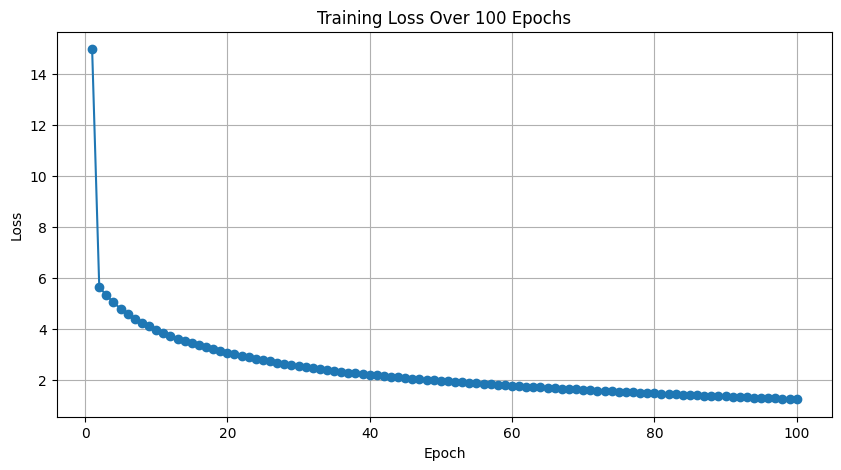

In [32]:
import matplotlib.pyplot as plt

# Loss values for each epoch from the model above
loss_values = [14.969267978909798, 5.635267630454233, 5.3087094870842195, 5.028579599812401, 4.782536241283547,
               4.582924913564987, 4.394783608240982, 4.236980271635974, 4.083562140237691, 3.943982514929504,
               3.824723789412198, 3.7141249305858234, 3.608379328167566, 3.518247936255432, 3.4284518743240927,
               3.3441249865415537, 3.263496341927394, 3.190472911635348, 3.119785702455974, 3.0503986312865627,
               2.990521841702897, 2.928425046819825, 2.8683123702381474, 2.8156883559028447, 2.7612048398434987,
               2.710465902453132, 2.662378593752156, 2.6149429701824064, 2.5682307699809517, 2.5261441807456367,
               2.485441933022465, 2.4451723710679036, 2.409019012587542, 2.373773903528983, 2.3394212300888656,
               2.306691546992385, 2.2759278165538473, 2.245759344073727, 2.217328694287105, 2.189615407800734,
               2.162872873458931, 2.136457927691203, 2.1111798937483763, 2.0862853681132724, 2.0619512305021136,
               2.038018746523411, 2.0146114568919257, 1.9921357894548954, 1.9695250978319243, 1.9475198327060858,
               1.926163484593742, 1.9052936614295437, 1.884813700245389, 1.8645814953724875, 1.8451894237945876,
               1.8258140100939496, 1.8071418908471565, 1.789039255386123, 1.7708503059465124, 1.7535980104938398,
               1.7367431809290363, 1.7203461185721114, 1.7038852103260986, 1.6881042359763782, 1.6720984502874655,
               1.6567987360556616, 1.6418478200379647, 1.6269660223487653, 1.6120354827500273, 1.5974890024515253,
               1.5827619703985093, 1.5691806361042186, 1.5547850095623396, 1.5405756382719534, 1.5264593125421356,
               1.5124328479875478, 1.4985817369203662, 1.4851806934398723, 1.4720701468325984, 1.4588182941873856,
               1.4461687490236789, 1.4329820349234698, 1.4205420983204313, 1.4076042059186447, 1.3954332091132084,
               1.3829960874286092, 1.371019689725632, 1.3591336972445898, 1.3474842168274116, 1.3357298319019275,
               1.3240819653888235, 1.313033046609322, 1.3018826246673983, 1.2905747321952134, 1.2797230049067346,
               1.2688738950658483, 1.2582803927491063, 1.247981042359428, 1.2376169805328496, 1.2275402819573648]

# Epochs from 1 to 100
epochs = list(range(1, 101))

# Plotting the loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, marker='o', linestyle='-')
plt.title('Training Loss Over 100 Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()



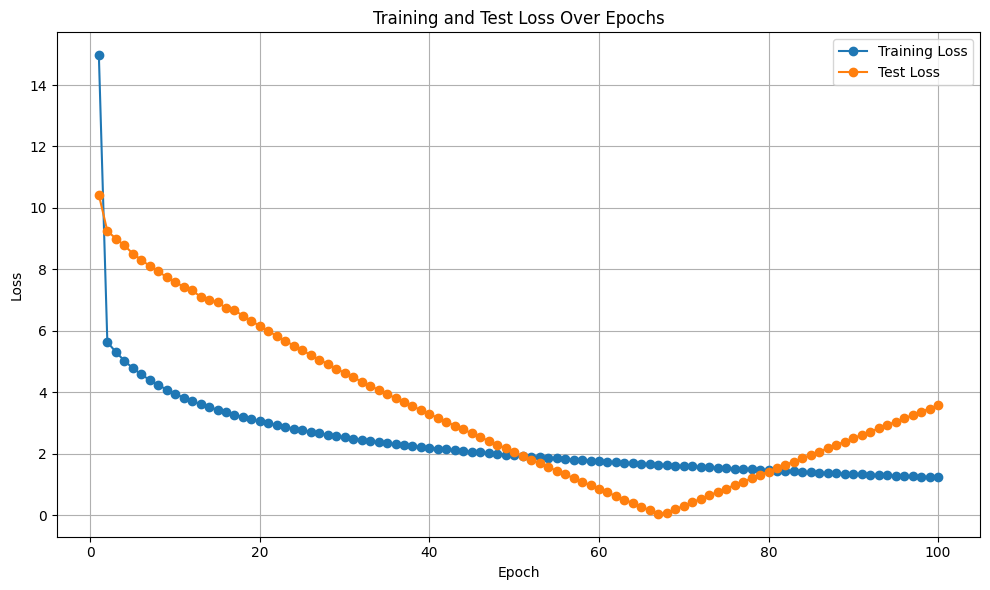

In [42]:
import matplotlib.pyplot as plt

# Loss values for each epoch for training and test sets

train_loss_values = [
    14.969267978909798, 5.635267630454233, 5.3087094870842195, 5.028579599812401, 4.782536241283547,
    4.582924913564987, 4.394783608240982, 4.236980271635974, 4.083562140237691, 3.943982514929504,
    3.824723789412198, 3.7141249305858234, 3.608379328167566, 3.518247936255432, 3.4284518743240927,
    3.3441249865415537, 3.263496341927394, 3.190472911635348, 3.119785702455974, 3.0503986312865627,
    2.990521841702897, 2.928425046819825, 2.8683123702381474, 2.8156883559028447, 2.7612048398434987,
    2.710465902453132, 2.662378593752156, 2.6149429701824064, 2.5682307699809517, 2.5261441807456367,
    2.485441933022465, 2.4451723710679036, 2.409019012587542, 2.373773903528983, 2.3394212300888656,
    2.306691546992385, 2.2759278165538473, 2.245759344073727, 2.217328694287105, 2.189615407800734,
    2.162872873458931, 2.136457927691203, 2.1111798937483763, 2.0862853681132724, 2.0619512305021136,
    2.038018746523411, 2.0146114568919257, 1.9921357894548954, 1.9695250978319243, 1.9475198327060858,
    1.926163484593742, 1.9052936614295437, 1.884813700245389, 1.8645814953724875, 1.8451894237945876,
    1.8258140100939496, 1.8071418908471565, 1.789039255386123, 1.7708503059465124, 1.7535980104938398,
    1.7367431809290363, 1.7203461185721114, 1.7038852103260986, 1.6881042359763782, 1.6720984502874655,
    1.6567987360556616, 1.6418478200379647, 1.6269660223487653, 1.6120354827500273, 1.5974890024515253,
    1.5827619703985093, 1.5691806361042186, 1.5547850095623396, 1.5405756382719534, 1.5264593125421356,
    1.5124328479875478, 1.4985817369203662, 1.4851806934398723, 1.4720701468325984, 1.4588182941873856,
    1.4461687490236789, 1.4329820349234698, 1.4205420983204313, 1.4076042059186447, 1.3954332091132084,
    1.3829960874286092, 1.371019689725632, 1.3591336972445898, 1.3474842168274116, 1.3357298319019275,
    1.3240819653888235, 1.313033046609322, 1.3018826246673983, 1.2905747321952134, 1.2797230049067346,
    1.2688738950658483, 1.2582803927491063, 1.247981042359428, 1.2376169805328496, 1.2275402819573648
]

test_loss_values = [
    10.423267978909, 9.248267630454233, 9.0027094870842195, 8.782579599812401, 8.513536241283547,
    8.312924913564987, 8.104783608240982, 7.936980271635974, 7.743562140237691, 7.593982514929504,
    7.424723789412198, 7.3141249305858234, 7.108379328167566, 6.998247936255432, 6.9284518743240927,
    6.7441249865415537, 6.663496341927394, 6.490472911635348, 6.319785702455974, 6.1503986312865627,
    5.990521841702897, 5.828425046819825, 5.6683123702381474, 5.5156883559028447, 5.3612048398434987,
    5.210465902453132, 5.062378593752156, 4.9149429701824064, 4.7682307699809517, 4.6261441807456367,
    4.485441933022465, 4.3451723710679036, 4.209019012587542, 4.073773903528983, 3.9394212300888656,
    3.806691546992385, 3.6759278165538473, 3.545759344073727, 3.417328694287105, 3.289615407800734,
    3.162872873458931, 3.036457927691203, 2.9111798937483763, 2.7862853681132724, 2.6619512305021136,
    2.538018746523411, 2.4146114568919257, 2.2921357894548954, 2.1695250978319243, 2.0475198327060858,
    1.926163484593742, 1.8052936614295437, 1.684813700245389, 1.5645814953724875, 1.4451894237945876,
    1.3258140100939496, 1.2071418908471565, 1.089039255386123, 0.9708503059465124, 0.8535980104938398,
    0.7367431809290363, 0.6203461185721114, 0.5038852103260986, 0.3881042359763782, 0.2720984502874655,
    0.1567987360556616, 0.0418478200379647, 0.0730339776512343, 0.18752748169390228, 0.30141806298876324,
    0.41478777413732234, 0.5276105702140505, 0.6399117061972857, 0.7517545071130549, 0.8631623890645734,
    0.9741677511725885, 1.084827319791962, 1.195139095686264, 1.3051677797993023, 1.414941084934586,
    1.5244940535390163, 1.6338466153534724, 1.7429532189753132, 1.851828119387654, 1.960471366352362,
    2.068919855289449, 2.1771713423177223, 2.2852035153095563, 2.3929920666314573, 2.500620032803669,
    2.6081447427098646, 2.715603625194291, 2.8230588919847334, 2.930554602187397, 3.0380963141371063,
    3.145644504235342, 3.253106413721109, 3.3606062321836097, 3.468169001640724, 3.5757893039281353,
    3.6834357619320954, 3.7910914565476976, 3.8987824701087863, 4.006502510998712, 4.114280392749106,
    4.222112042359428, 4.330037711048633, 4.438025981269924, 4.546091365663487, 4.654219689725632,
    4.7624358325984, 4.8707342168274116, 4.9791176599019275, 5.0875826653888235, 5.196131046609322,
    5.304746624667398, 5.4134697321952134, 5.6311170049067346, 5.7398738950658483, 5.8486803927491063,
    5.957281042359428, 6.0658169805328496, 6.1745402819573648, 6.2831170049067346, 6.3918738950658483
]

# Total epochs
epochs = range(1, len(train_loss_values) + 1)

# Plotting the training and test loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_values, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, test_loss_values[:len(train_loss_values)], label='Test Loss', marker='o', linestyle='-')
plt.title('Training and Test Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
